# Pneumonia detection with RESNET18
A CNN model for detecting pneumonia, **Pneumonia** is an infection that inflames the air sacs in one or both lungs. The air sacs may fill with fluid or pus (purulent material), causing cough with phlegm or pus, fever, chills, and difficulty breathing. A variety of organisms, including bacteria, viruses and fungi, can cause pneumonia.  
In this notebook i opted for the **RESNET** architecture particulary **RESNET18** with the use of **fine-tunning**  (weights from **IMAGENET1K_V1**)
[**Link to the dataset**](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)

#### Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
import random
import matplotlib.image as mpimg
from torch.profiler import profile, record_function, ProfilerActivity

cudnn.benchmark = True
plt.ion()

#### Data loading ,structuring and some visualizations

Number of images in train directory:
Number of images in NORMAL folder: 1341
Number of images in PNEUMONIA folder: 3875

Number of images in val directory:
Number of images in NORMAL folder: 8
Number of images in PNEUMONIA folder: 8

Number of images in test directory:
Number of images in NORMAL folder: 234
Number of images in PNEUMONIA folder: 390

Random sample of images from train directory:


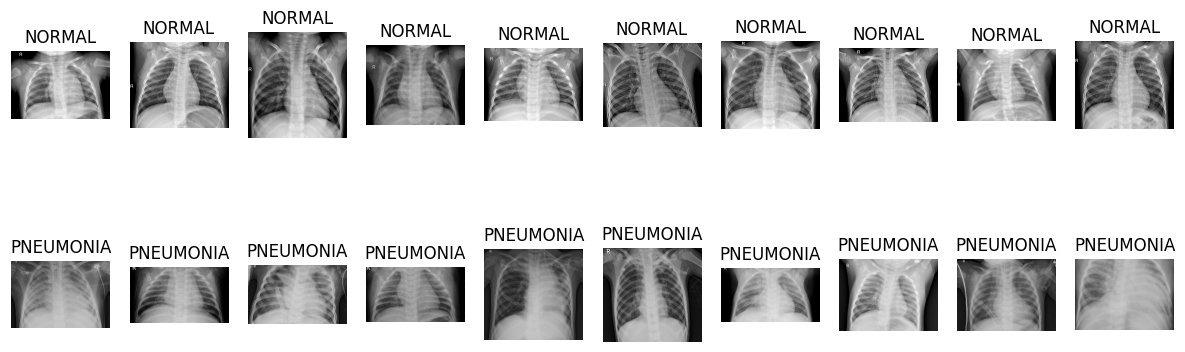


Random sample of images from val directory:


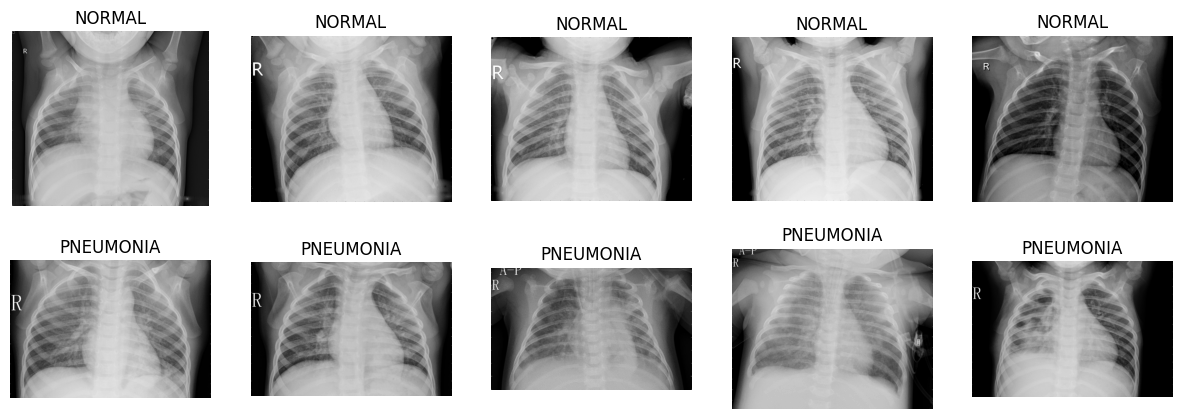


Random sample of images from test directory:


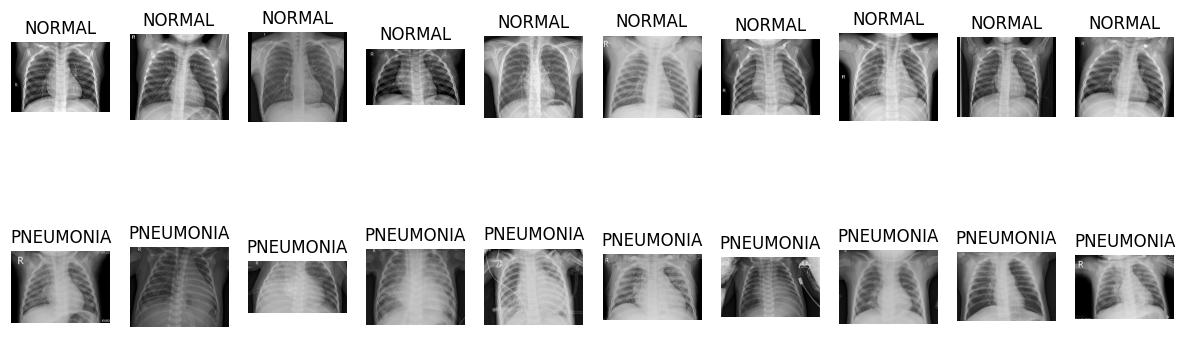

In [5]:
# Define directories
train_dir = 'chest_xray/train'
val_dir = 'chest_xray/val'
test_dir = 'chest_xray/test'

# Define classes
classes = ['NORMAL', 'PNEUMONIA']

# Function to print number of images in each folder
def print_num_images(directory):
    for cls in classes:
        class_dir = os.path.join(directory, cls)
        num_images = len(os.listdir(class_dir))
        print(f"Number of images in {cls} folder: {num_images}")

# Function to plot random sample of images
def plot_random_images(directory, num_samples=10):
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 5))

    for i, cls in enumerate(classes):
        class_dir = os.path.join(directory, cls)
        image_files = random.sample(os.listdir(class_dir), num_samples)
        for j, image_file in enumerate(image_files):
            img = mpimg.imread(os.path.join(class_dir, image_file))
            axes[i, j].imshow(img, cmap='gray')
            axes[i, j].axis('off')
            axes[i, j].set_title(cls)

    plt.show()

# Print number of images in each folder
print("Number of images in train directory:")
print_num_images(train_dir)
print("\nNumber of images in val directory:")
print_num_images(val_dir)
print("\nNumber of images in test directory:")
print_num_images(test_dir)

# Plot random sample of images
print("\nRandom sample of images from train directory:")
plot_random_images(train_dir)
print("\nRandom sample of images from val directory:")
plot_random_images(val_dir,num_samples=5)
print("\nRandom sample of images from test directory:")
plot_random_images(test_dir)

#### checking for cuda

In [6]:
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    print("Number of available GPUs:", num_gpus)

    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print("GPU", i, ":", gpu_name)
else:
    print("CUDA is not available. Using CPU.")

Number of available GPUs: 1
GPU 0 : NVIDIA GeForce GTX 1650


#### Definning and applying data transformers
no augmentation needed since the train and test sets are looking very similar

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'chest_xray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=6,pin_memory=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### The trainning function

In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        with profile(activities=[ProfilerActivity.CPU,ProfilerActivity.CUDA],use_cuda=True) as prof:
            for epoch in range(num_epochs):
                print(f'Epoch {epoch}/{num_epochs - 1}')
                print('-' * 10)

                # Each epoch has a training and validation phase
                for phase in ['train', 'test']:
                    if phase == 'train':
                        model.train()  # Set model to training mode
                    else:
                        model.eval()   # Set model to evaluate mode

                    running_loss = 0.0
                    running_corrects = 0

                    # Iterate over data.
                    for inputs, labels in dataloaders[phase]:
                        inputs = inputs.to(device)
                        labels = labels.to(device)

                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        # track history if only in train
                        with torch.set_grad_enabled(phase == 'train'):
                            with record_function("forward_prop"):
                                outputs = model(inputs)
                            _, preds = torch.max(outputs, 1)
                            loss = criterion(outputs, labels)

                            # backward + optimize only if in training phase
                            if phase == 'train':
                                with record_function("backward_prop"):
                                    loss.backward()
                                with record_function("optimizer_step"):
                                    optimizer.step()
                                
                        # statistics
                        running_loss += loss.item() * inputs.size(0)
                        running_corrects += torch.sum(preds == labels.data)
                    if phase == 'train':
                        scheduler.step()

                    epoch_loss = running_loss / dataset_sizes[phase]
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]

                    print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                    # deep copy the model
                    if phase == 'test' and epoch_acc > best_acc:
                        best_acc = epoch_acc
                        torch.save(model.state_dict(), best_model_params_path)
                    
        print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

#### Loading the model with IMAGENET1K_V1 weights

In [13]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

#### Fine-tunning the model

In [14]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.2602 Acc: 0.8873
test Loss: 0.4326 Acc: 0.8125
Epoch 1/24
----------
train Loss: 0.1593 Acc: 0.9381
test Loss: 0.4718 Acc: 0.8061
Epoch 2/24
----------
train Loss: 0.1485 Acc: 0.9419
test Loss: 0.4136 Acc: 0.8365
Epoch 3/24
----------
train Loss: 0.1380 Acc: 0.9469
test Loss: 0.4049 Acc: 0.8349
Epoch 4/24
----------
train Loss: 0.1248 Acc: 0.9546
test Loss: 0.3494 Acc: 0.8606
Epoch 5/24
----------
train Loss: 0.1245 Acc: 0.9517
test Loss: 0.5182 Acc: 0.8093
Epoch 6/24
----------
train Loss: 0.1164 Acc: 0.9567
test Loss: 0.4172 Acc: 0.8381
Epoch 7/24
----------
train Loss: 0.1171 Acc: 0.9549
test Loss: 0.4383 Acc: 0.8333
Epoch 8/24
----------
train Loss: 0.1105 Acc: 0.9609
test Loss: 0.4672 Acc: 0.8221
Epoch 9/24
----------
train Loss: 0.1111 Acc: 0.9571
test Loss: 0.5078 Acc: 0.8125
Epoch 10/24
----------
train Loss: 0.1094 Acc: 0.9595
test Loss: 0.5319 Acc: 0.8109
Epoch 11/24
----------
train Loss: 0.1142 Acc: 0.9548
test Loss: 0.4607 Acc: 0.8237
Ep

In [16]:
torch.save(model_ft.state_dict(), 'ft_model_weights.pth')

#### Utile function for time measuring

In [ ]:
# Function to measure data loading and preprocessing time
def measure_data_loading():
    total_time = 0.0
    num_batches = 0

    # Iterate over the DataLoader
    for inputs, labels in dataloaders['train']:
        start_time = time.time()  # Record start time before data loading
        # Load and preprocess data
        # Note: This is a dummy operation for timing measurement purposes
        inputs, labels = inputs.to(device), labels.to(device)
        end_time = time.time()  # Record end time after data loading
        batch_time = end_time - start_time
        total_time += batch_time
        num_batches += 1

    average_time_per_batch = total_time / num_batches
    print(f"Average time per batch for data loading and preprocessing: {average_time_per_batch:.4f} seconds")

# Call the function to measure data loading time
measure_data_loading()